# Spectral Relaxation for K-means Clustering

## Stari kod - ne gledati

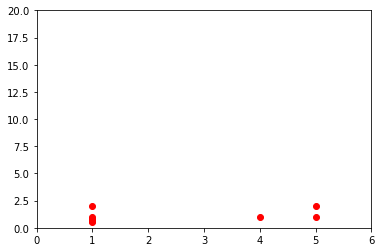

In [88]:
"""
A = np.array([[1,1,4,5,5], [1, 2,1,1,2]]) #jednostavan primjer
plt.plot(A[0,:],A[1,:], 'ro')
plt.axis([0, 6, 0, 20])
plt.show()


centri = np.array([[10, 2], [-4, 3]], dtype=float)
A = [np.random.randn(2, 50) + np.expand_dims(centar, axis=1) 
    for centar in centri]
A = np.concatenate(A, axis=1)

A = pd.DataFrame(A)
print(A)
nmax = 5
k = 3

while True:
    starting_partition = np.random.randint(0, k, A.shape[1])
    s_i = np.unique(starting_partition, axis=0, return_counts=True)[1]
    if len(s_i) == k:
        break

A.columns = starting_partition 

for n in tqdm(range(nmax)):
    s_i = np.unique(starting_partition, axis=0, return_counts=True)[1]
    a_i = A.groupby(level=0,axis=1).sum().add_suffix('_centroid_klastera')
    m_i = a_i / s_i 
    for i in range(A.shape[1]): 
        distance_final = np.inf
        for j in range(0, m_i.shape[1]):
            distance = np.linalg.norm((A.iloc[:,i] - m_i.iloc[:,j]))
            if(distance < distance_final):
                distance_final = distance
                tmp = list(A.columns)
                tmp[i] = j
                A.columns = tmp  
    starting_partition = A.columns.values 

print(A)   
print(m_i)

plt.plot(A.iloc[0,:],A.iloc[1,:], 'ro')
plt.plot(m_i.iloc[0,:],m_i.iloc[1,:], 'bx', ms=10)
plt.show()
#plavi centroidi

## Teorijski dio 

In [5]:
#učitavanje podataka

import scipy.io
import pandas as pd
import numpy as np

mat_1 = scipy.io.loadmat('azip.mat')
A = mat_1['azip'] #data

mat_2 = scipy.io.loadmat('dzip.mat')
D = mat_2['dzip'] #data

k = 10 #number of clasters

Prvo ćemo presložiti matricu podataka(**A**) na način da združimo one elemente koji pripadaju istom klasteru i napravimo od njih blokove. Nakon toga, pomoću kreiranih blokova, računamo broj elementa klastera(**$s_i$**) i nove centroide (**$m_i$**) pomoću formula s prezentacije(*prva prezentacija - slajd 35*).

In [3]:
new_A = np.empty([A.shape[0],0])
s_i = np.empty(k, dtype=int) 
m_i = np.empty([A.shape[0],k])
permutation = np.empty(0,) 

for i in range(k):
    A_i = A[:, np.where(D == i)[1]] 
    permutation = np.append(permutation, np.where(D == i)[1], axis=0) 
    new_A = np.append(new_A, A_i, axis=1)
    s_i[i] = np.where(D == i)[1].shape[0]
    e = np.ones(s_i[i])
    m_i[:,i] = (1/s_i[i]) * np.matmul(A_i, e) 


Konačno, formuliramo matricu X koja će sadržavati informacije o pripadnosti elementa početnoj particiji.

In [4]:
X = np.zeros([A.shape[1],k])

for i in range(k):
    if( i == 0):
        X[i:s_i[i], 0] = 1/s_i[1]
    else:
        X[ s_i[0:i].sum() : s_i[0:i].sum() + s_i[i], i] = 1/s_i[i-1]

Na kraju, preostaje ponovo inverzno djelovati istom permutacijom na matricu $X$ kako bismo dobili $\tilde{X}$.

In [5]:
X_tilde = np.zeros([A.shape[1],k])

for i in range(X.shape[0]):
    index = list(permutation).index(i)  
    X_tilde[int(permutation[i]), :] = X[i, :] 

Preostaje zapisati početnu particiju.

In [6]:
start_partition = np.empty(D.shape[1], dtype=int)

for i in range(X.shape[0]):
    start_partition[i] = int(np.where(X_tilde[i, :] != 0)[0])

In [7]:
from sklearn.metrics import accuracy_score

start_partition = np.reshape(start_partition, (D.shape[1],1))
accuracy_score(start_partition, np.transpose(D))

1.0

Vidimo da se ova početna particija 100% podudara s točnim rješenjima.

## K-means pomoću linearne algebre

In [4]:
from sklearn.metrics import accuracy_score

mat_3 = scipy.io.loadmat('dtest.mat')
mat_2 = scipy.io.loadmat('testzip.mat')
Dt = mat_3['dtest']

At = mat_2['testzip']

niz_test = Dt[0]
niz = D[0]

baze_prostora_znamenki = dict()

for i in range (k):
    J = [j for j, x in enumerate(niz) if x == i] 
    B = A[:,J]
    U, S, V = np.linalg.svd(B)
    baze_prostora_znamenki[i] = U[:,0:k]
    
n = len(niz_test)
rez = np.zeros(n)


brojac = 0
br = 0
for i in range (n):
    z = At[:,i]
    y = np.dot(baze_prostora_znamenki[0],baze_prostora_znamenki[0].T)
    x = np.dot(y,z)
    min_udaljenost = np.linalg.norm(z - x)
    klaster = 0
    for j in range (1,10):
        y = np.dot(baze_prostora_znamenki[j],baze_prostora_znamenki[j].T)
        x = np.dot(y,z)
        udaljenost = np.linalg.norm(z - x)
        if (udaljenost < min_udaljenost):
            #print(j)
            min_udaljenost = udaljenost
            klaster = j 
    rez[i] = klaster
  


accuracy_score(rez,niz_test)


0.931738913801694

## Finalno rješenje

Učitavanje podataka:


In [9]:
import scipy.io
import pandas as pd
import numpy as np

mat_1 = scipy.io.loadmat('azip.mat')
A = mat_1['azip'] #data

mat_2 = scipy.io.loadmat('dzip.mat')
D = mat_2['dzip'] #data


mat_3 = scipy.io.loadmat('dtest.mat')
mat_2 = scipy.io.loadmat('testzip.mat')
Dt = mat_3['dtest']

At = mat_2['testzip']

niz_test = Dt[0]
niz = D[0]

k=10

K_means_1(A, At, niz, niz_test, k)

In [ ]:
import scipy.io
import pandas as pd
import numpy as np

mat_1 = scipy.io.loadmat('azip.mat')
A = mat_1['azip'] #data
A = A[:, 0:50]

A = A.byteswap().newbyteorder()
A = pd.DataFrame(A)

mat_2 = scipy.io.loadmat('dzip.mat')
D = mat_2['dzip'] #data
D = D[:, 0:50]
k = 10 

while True: #još uvijek nemamo dobru ideju za početnu particiju pa je ona random zasad
    starting_partition = np.random.randint(0, k, A.shape[1])
    s_i = np.unique(starting_partition, axis=0, return_counts=True)[1]
    if len(s_i) == k:
        break



epsilon = 0.00001

K_means_2(A,starting_partition, k, epsilon) 

Prema poglavlju dva u članku, koristeći spektralnu relaksaciju smanjit ćemo dimenzije matrice A, ali svejedno očuvati sve potrebne informacije. Uzimamo samo k prvih svojstvenih vektora. Na taj način formiramo matricu X_k na čije retke primjenjujemo k-means. Svaki podatak više nije 1x256, već 1x10! - Velika ušteda memorije!

Prvi način relaksije:

In [20]:
from scipy.linalg import eigh

eigenvalues, eigenvectors = eigh(np.transpose(A) @ A) 

eigenvalues = eigenvalues[A.shape[1]-k:A.shape[1]][::-1] 
X_k = np.flip(eigenvectors[:, (A.shape[1]-k):A.shape[1]] ,axis=1)


In [21]:
pd.DataFrame(X_k)

,0,1,2,3,4,5,6,7,8,9
0,-0.080261,0.158458,0.146344,0.075466,-0.092041,0.004512,-0.010847,-0.006441,0.084212,0.128041
1,-0.040928,0.149799,-0.011916,-0.139635,-0.120211,-0.143306,0.041295,0.068432,-0.163216,0.133591
2,-0.093066,0.058889,-0.030985,0.171445,-0.018936,0.100938,0.203378,-0.101044,0.065286,0.011539
3,-0.119396,-0.063160,-0.181185,0.001965,-0.005684,-0.069925,-0.016849,0.009450,0.023683,0.015812
4,-0.085921,0.109147,-0.022548,-0.266008,-0.064803,0.046679,0.099236,-0.037256,-0.066887,-0.022213
...,...,...,...,...,...,...,...,...,...,...
95,-0.036550,0.180168,0.058374,-0.000519,-0.195549,-0.285158,-0.091823,-0.004770,0.025162,-0.175828
96,-0.086891,-0.008140,-0.079819,0.000684,0.021268,0.196336,-0.132219,-0.168143,0.143436,0.089795
97,-0.095168,0.206842,0.059285,0.021017,0.063423,0.053159,0.107120,0.057621,-0.058249,-0.111400
98,-0.086677,-0.050554,0.083049,0.067205,0.008636,-0.056683,-0.093446,-0.311376,0.067425,0.073984


Primjena standarnog k-meanse na retke od X_k(**reducirane podatke**).

In [53]:
A = pd.DataFrame(np.transpose(X_k)) #transponiramo jer smo pisali algoritam na način da smo računali da je jedan podatak - jedan stupac

while True: #još uvijek nemamo dobru ideju za početnu particiju pa je ona random zasad
    starting_partition = np.random.randint(0, k, A.shape[1])
    s_i = np.unique(starting_partition, axis=0, return_counts=True)[1]
    if len(s_i) == k:
        break
    

A.columns = starting_partition
partition = starting_partition

number_of_iteration = 0
epsilon = 0.000001

Q_of_partition = np.inf

while(Q_of_partition > epsilon):
    
    number_of_iteration += 1

    s_i = np.unique(partition, axis=0, return_counts=True)[1]
    a_i = A.groupby(level=0,axis=1).sum().add_suffix('. centroid')
    m_i = a_i / s_i 
    
    Q_of_partition_before = 0
    for i in range(A.shape[1]):
        Q_of_partition_before  += np.linalg.norm((A.iloc[:,i] - m_i.iloc[:,A.columns[i]]))
        
    for i in range(A.shape[1]): 
        distance_final = np.inf
        for j in range(0, m_i.shape[1]):
            distance = np.linalg.norm((A.iloc[:,i] - m_i.iloc[:,j]))
            if(distance < distance_final):
                distance_final = distance
                tmp = list(A.columns)
                tmp[i] = j
                A.columns = tmp 
                
    partition = A.columns.values
    
    Q_of_partition_after = 0
    for i in range(A.shape[1]):
        Q_of_partition_after  += np.linalg.norm((A.iloc[:,i] - m_i.iloc[:,A.columns[i]]))
    
    Q_of_partition = Q_of_partition_before - Q_of_partition_after

print("Broj iteracija je", number_of_iteration)
print("Kordinate centroida su", m_i)
print("Elementi redom pripadaju sljedećim klasterima", A.columns)

Broj iteracija je 16
Kordinate centroida su    0. centroid  1. centroid  2. centroid  3. centroid  4. centroid  \
0    -0.027447    -0.015898    -0.025331    -0.028844    -0.034079   
1    -0.048556    -0.048944    -0.049373    -0.012187     0.013450   
2    -0.000551     0.003862     0.013147    -0.019410    -0.025421   
3    -0.005457    -0.068847     0.030495    -0.000378     0.001087   
4    -0.008273     0.002237    -0.006840     0.052971    -0.027673   
5     0.008602    -0.012473    -0.000960     0.007127     0.007518   
6    -0.013864     0.015595     0.024164    -0.026561     0.006705   
7    -0.001159    -0.010639     0.004942    -0.009993    -0.032932   
8     0.020174     0.007521    -0.020214    -0.017099    -0.014165   
9     0.041181    -0.031535     0.021814     0.003958     0.005370   

   5. centroid  6. centroid  7. centroid  8. centroid  9. centroid  
0    -0.041117    -0.026963    -0.031284    -0.031339    -0.033776  
1     0.037876     0.002112     0.011549     0.

Provjera koliko smo "blizu":

In [43]:
print("Pogodili smo ", np.sum(D == np.array(A.columns)), " elementa od ukupno", D.shape[1], "!")

Pogodili smo  9  elementa od ukupno 1000 !


Ono što dalje pokušavamo jest utvrditi najbolju moguću početnu particiju -> poboljšanje relaksiranog problema pomoću QR.

In [44]:
Q, R, P = scipy.linalg.qr(np.transpose(X_k), pivoting = True)

P_ = np.zeros([A.shape[1],A.shape[1]])
for i in range(A.shape[1]):
    P_[P[i],i] = 1


R_11 = R[0:k, 0:k]
R_12 = R[0:k, k:R.shape[1]]

I = np.eye(k, dtype=int)
R = np.matmul(np.linalg.inv(R_11), R_12)

R_kapa = np.append(I,R,axis=1)  @  np.transpose(P_)
R_kapa = np.absolute(R_kapa)
starting_partition = np.argmax(R_kapa, axis=0)

Ponovo provodimo k-means, ali sada početna particija nije random!

In [45]:
A = pd.DataFrame(A)

partition = starting_partition
A.columns = partition 

number_of_iteration = 0
epsilon = 0.00001

Q_of_partition = np.inf

while(Q_of_partition > epsilon):
    
    number_of_iteration += 1
    
    Q_of_partition_before = 0
    for i in range(A.shape[1]):
        Q_of_partition_before  += np.linalg.norm((A.iloc[:,i] - m_i.iloc[:,A.columns[i]]))
    
    s_i = np.unique(partition, axis=0, return_counts=True)[1]
    a_i = A.groupby(level=0,axis=1).sum().add_suffix('. centroid')
    m_i = a_i / s_i 
    for i in range(A.shape[1]): 
        distance_final = np.inf
        for j in range(0, m_i.shape[1]):
            distance = np.linalg.norm((A.iloc[:,i] - m_i.iloc[:,j]))
            if(distance < distance_final):
                distance_final = distance
                tmp = list(A.columns)
                tmp[i] = j
                A.columns = tmp  
    partition = A.columns.values
    
    Q_of_partition_after = 0
    for i in range(A.shape[1]):
        Q_of_partition_after  += np.linalg.norm((A.iloc[:,i] - m_i.iloc[:,A.columns[i]]))
    
    Q_of_partition = Q_of_partition_before - Q_of_partition_after

print("Broj iteracija je", number_of_iteration)
print("Kordinate centroida su", m_i)
print("Elementi redom pripadaju sljedećim klasterima", A.columns)

Broj iteracija je 14
Kordinate centroida su    0. centroid  1. centroid  2. centroid  3. centroid  4. centroid  \
0    -0.029985    -0.030154    -0.016089    -0.026218    -0.026040   
1     0.010173     0.006041    -0.049447    -0.054463    -0.000180   
2    -0.053455     0.005928     0.003765     0.006779     0.008132   
3    -0.014992     0.002704    -0.066641     0.010207     0.004243   
4    -0.029094    -0.041877     0.000310    -0.005411    -0.012121   
5     0.014970     0.009336    -0.012779     0.005376    -0.061860   
6     0.006589    -0.020508     0.014389     0.007069    -0.042553   
7     0.052067    -0.031145    -0.009388     0.000830     0.010660   
8    -0.007765     0.021585     0.008232    -0.000462    -0.010009   
9    -0.014526    -0.003619    -0.026973     0.037771    -0.007143   

   5. centroid  6. centroid  7. centroid  8. centroid  9. centroid  
0    -0.033291    -0.031238    -0.028808    -0.036240    -0.041303  
1    -0.014958     0.000578    -0.013361     0.

Provjera koliko smo "blizu":

In [46]:
print("Pogodili smo ", np.sum(D == np.array(A.columns)), " elementa od ukupno", D.shape[1], "!")

Pogodili smo  24  elementa od ukupno 1000 !


In [22]:
def K_means(A, k, starting_partition, epsilon): #A is np.array, k is number of clasters, starting_partition is starting partition, epsilon is stop criterion
    
    A = pd.DataFrame(A)
    partition = starting_partition
    A.columns = partition 

    number_of_iteration = 0
    epsilon = 0.00001

    Q_of_partition = np.inf

    while(Q_of_partition > epsilon):
    
        number_of_iteration += 1
    
        s_i = np.unique(partition, axis=0, return_counts=True)[1]
        a_i = A.groupby(level=0,axis=1).sum().add_suffix('. centroid')
        m_i = a_i / s_i 
        
        Q_of_partition_before = 0
        for i in range(A.shape[1]):
            Q_of_partition_before  += np.linalg.norm((A.iloc[:,i] - m_i.iloc[:,A.columns[i]]))
            
        for i in range(A.shape[1]): 
            distance_final = np.inf
            for j in range(0, m_i.shape[1]):
                distance = np.linalg.norm((A.iloc[:,i] - m_i.iloc[:,j]))
                if(distance < distance_final):
                    distance_final = distance
                    tmp = list(A.columns)
                    tmp[i] = j
                    A.columns = tmp  
        partition = A.columns.values
    
        Q_of_partition_after = 0
        for i in range(A.shape[1]):
            Q_of_partition_after  += np.linalg.norm((A.iloc[:,i] - m_i.iloc[:,A.columns[i]]))
    
        Q_of_partition = Q_of_partition_before - Q_of_partition_after
        
    return (A, m_i)
    

In [23]:
K_means(A,10,starting_partition,0.0001)

NameError: name 'starting_partition' is not defined

In [ ]:
solution = np.zeros(D_test[0].shape[0])

for i in range(D_test[0].shape[0]):
    claster = D_test[1][i]
    index = np.where(A_train[-1, :] == claster)[0]
    numbers = D_train[0][index]
    if(numbers.size != 0 ):
        solution[i] = mode(numbers)
    #else:
        #final_number = D_test[0][i]
    
        
print(solution)